In [20]:
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pylab
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
from textblob import TextBlob

%matplotlib inline

In [2]:
leaders_accounts = [
    'readDonaldTrump',
    'thepmo',
    'BorisJohnson',
    'Theresa_May',
    'JustinTrudeau'
]

In [29]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [30]:
dt_tweets = []
with open('./data/realDonaldTrump.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count != 0:
            dt_tweets.append(clean_tweet(row[6]))
        line_count += 1

In [31]:
dt_text = ''
for t in dt_tweets:
    dt_text += t
dt_wc = WordCloud().generate(dt_text)

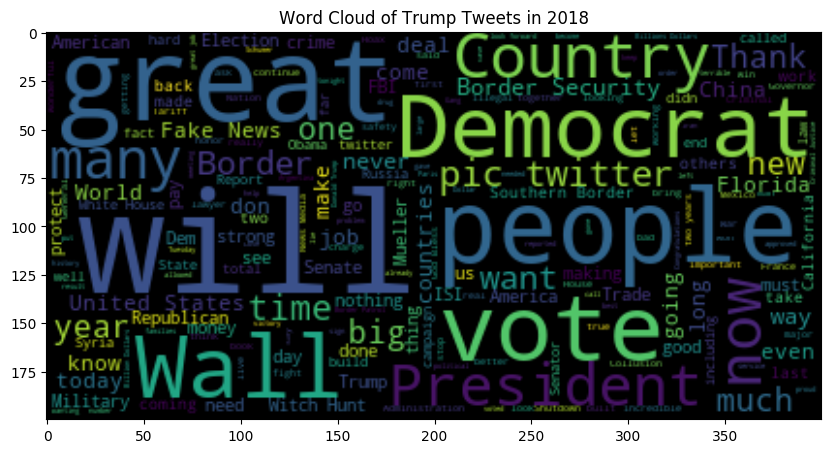

In [32]:
plt.figure(
    figsize=(10, 6),
    dpi=100)
plt.title('Word Cloud of Trump Tweets in 2018')

plt.imshow(dt_wc, interpolation='bilinear')
plt.show()

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/duncangrubbs/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
avg = [0.0, 0.0, 0.0]
print(avg[0])
for tweet in dt_tweets:
    ss = sid.polarity_scores(tweet)
    avg[0] += ss['neg']
    avg[1] += ss['pos']
    avg[2] += ss['neu']
avg[0] /= len(dt_tweets)
avg[1] /= len(dt_tweets)
avg[2] /= len(dt_tweets)
print(avg)

0.0
[0.08655599999999995, 0.16967199999999993, 0.7417439999999992]


In [24]:
analysis = TextBlob(clean_tweet(dt_text))
analysis.sentiment

Sentiment(polarity=0.14141448648822408, subjectivity=0.5347664810595291)